# Hierarchical Binomial Model: Rat Tumor Example

https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as ans
import theano.tensor as tt

import scipy.stats as stats
from scipy.special import gammaln 

print(f'Running on PyMC3 v{pm.__version__}')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.9.3


In [2]:
%config InlineBackend.figure_format = 'retina'
#az.style.use('arviz-darkgrid')

The rat tumour example found in chapter 5 of Bayesian Data Analysis 3rd Edition. Readers should already be familliar with the pymc3 api.

## Data from BDA3

- 71 trials, each trial has $n_i$ subjects resulting in $y_i$ cases of positive tumor.

In [9]:
# rat data (BDA3, p. 102)
# fmt: off
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
# fmt: on

N = len(n)
print(f'Total {N} trials.')
print(f'In total, Tumor Rate = {sum(y)/sum(n):.2} for {sum(y)} out of {sum(n)} rats.')

Total 71 trials.
In total, Tumor Rate = 0.15 for 267 out of 1739 rats.


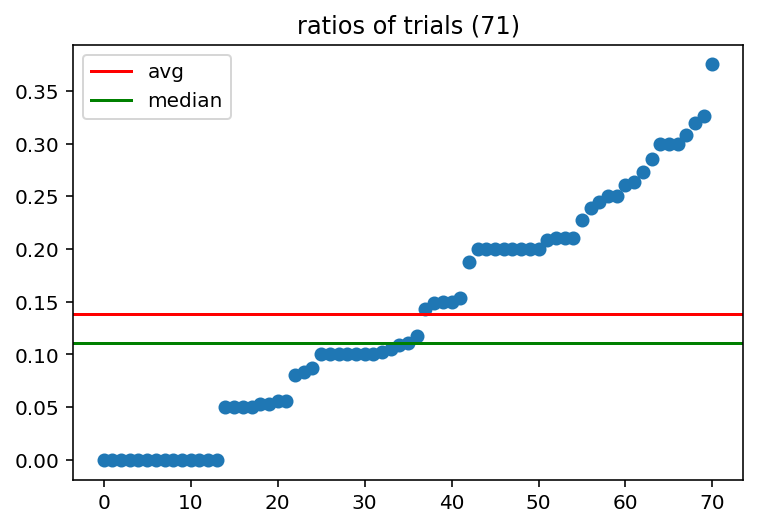

In [4]:
r = y / n
r.sort()
avg = r.mean()
median = np.median(r)

plt.plot(r, 'o')
plt.title(f'ratios of trials ({N})');
plt.axhline(y=avg, c='r', label='avg')
plt.axhline(y=median, c='g', label='median')
plt.legend();

## Beta - Binomial Conjugate Modeling for Each Trial

When each trial is modelled by beta-binomial conjugate pair,
$$
y_i \sim Binomial(n_i, \theta_i) \quad \Leftrightarrow \quad p(y_i | \theta_i) = Binomial(y_i | n_i, \theta_i) \\
\theta_i \sim Beta(\alpha_i, \beta_i) \quad \Leftrightarrow \quad p(\theta_i) = Beta(\theta_i| \alpha_i, \beta_i)
$$
the posterior is given by
$$
    p(\theta_i | y_i) = Beta(\theta_i | \alpha_i + y_i, \beta_i + n_i - y_i) \\
    = \frac{p(y_i|\theta_i) p(\theta_i | \alpha_i, \beta_i)}{ \int   }
$$

Here we do not need to perform integration to obtain the posterior distriubtion.

### Let's see about the case: n=47, y=15
- $\alpha_i$ = $\beta_i$ = 1 for a flat (non-informative) prior

In [5]:
n_i = n[-3]
y_i = y[-3]
print(f'y= {y_i} out of {n_i}: {y_i/n_i:.2}')
ai, bi = 1, 1
ap, bp = ai + y_i, bi + n_i - y_i

y= 15 out of 47: 0.32


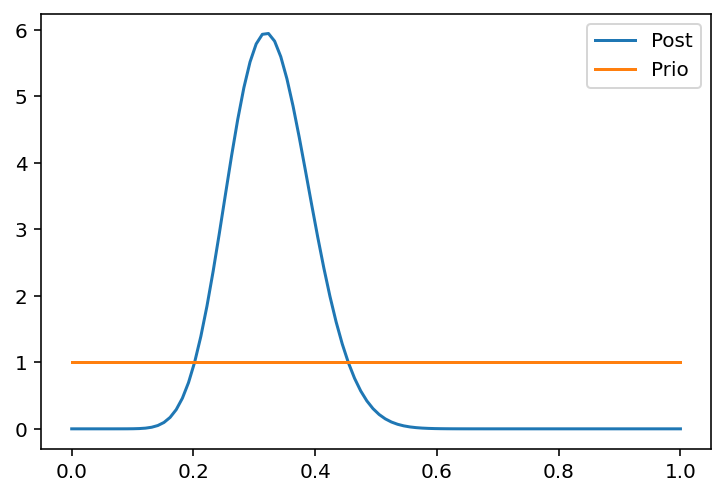

In [6]:
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta(a=ap, b=bp).pdf(x), label='Post');
plt.plot(x, stats.beta(a=ai, b=bi).pdf(x), label='Prio');
plt.legend();

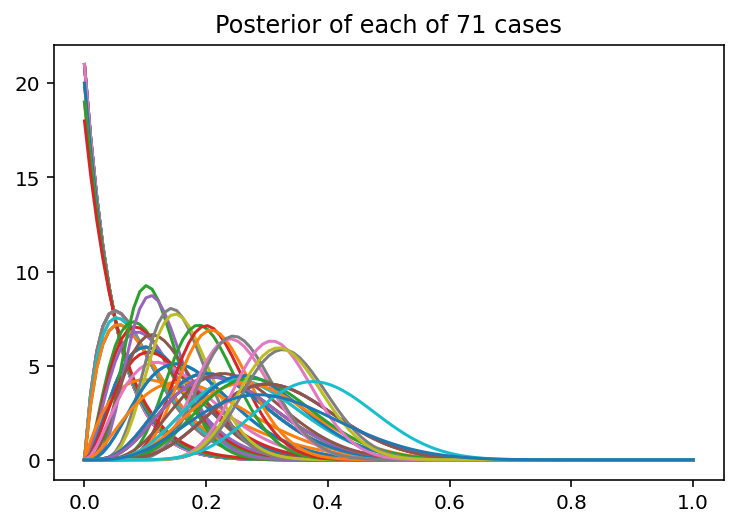

In [8]:
plt.figure()
plt.title(f'Posterior of each of {N} cases')
for yi, ni in zip(y, n):
#     print(f'y= {yi} out of {ni}: {yi/ni:.2}')
    ai, bi = 1, 1
    ap, bp = ai + yi, bi + ni - yi
    plt.plot(x, stats.beta(a=ap, b=bp).pdf(x), label=f'{yi}/{ni}');

## 2. Hierarchical Model

- Based on [Bayesian Inference and Decision Theory Unit 7: Hierarchical Bayesian Models by Kathryn Blackmond Laskey, George Mason University](http://seor.vse.gmu.edu/~klaskey/SYST664/SYST664.html)
- Here PyMC3 NUTS Sampling instead of Jags Gibbs Sampling

#### 2.1 Learning Objectives
- Specify hierarchical models (aks multi-level models) for comparing samples from subgroups of a population
    - Each sample consists of iid observations from a subgroup of a larger population
    - Parameters for the groups are viewed as a sample from a larger population of groups
    - Information can be shared across groups
- Explain the benefits of Bayesian hierarchical models for complex multi-parameter problems
- Inference in hierarchical models
- Evaluate structural assumptions in hierarchical models

#### 2.2 Hierarchical Models
- Use structural assumptions to achieve better statistical power without sacrificing realism
    - Parameters are often related to each other by structure of the problem
    - Hierarchical models exploit the relationship
    - "Borrow strength" from data used to estimate related parameters
    - Flexibly adapt dimensionality of model to exploit the information in the data
- Address tension between realism and statistical power
    - different from frequentist inference requiring too many parameters for realistic models
    - frequentist method not recommended; well I knot know exactly why.

#### 2.3 Rat Tumors
- BDA3 Section 5.1 - 5.3, Gelman, et.al.
- Studies are commonly performed on rats to evaluate effects of drugs
- The observations come from a set of 71 studies; rats were given a substance and evaluated for the presence of tumors
    - $y_s$ is the number of rats out of $n_s$ rats in the $s$-th study which developed tumors
    - Model for $y_s$:
        - Tumors occur indenpendently with probability $\theta_s$
        - $y_s$ is drawn from a Binomial($n_s$, $\theta_s$)
    - The **question of interest** is whether $\theta_s$s are different for different studies.
- Modeling choices:
    1. Pool all data and estimate a single tumor probability
        - not supported by the data
    1. Independent analyses for each of the 71 studies
        - low statistical power, especially for studies with small sample size
    1. Hierarchical model
        - gives us benefits of both approaches without drawbacks of either

#### 2.4 Pooled Model of Tumor Probability

- Pooled model:
    - All studies have the same probability $\theta$ of each rat developing tumor
    - Uniform beta(1,1) prior for $\theta$
    - Observations: 267 out of 1739 rats have tumors
    - Posterior is also a beta with:
    $$
        \begin{align}
        \alpha^* & =  1 + \sum_s y_s \\
        \beta^*  & = 1 + \sum_s n_s - \sum_s y_s
        \end{align}
    $$
    - Posterior expected probability (mean) a rat will have a tumor
    $$
        \mathbb{E}[\theta|Y] = \bar\theta_{|Y} = \frac{\alpha^*}{\alpha^* + \beta^*} = 0.154 \quad \mbox{where } Y=\{y_s\}
    $$
    - Posterior predictive distribution for a new study of size $n$ is beta-binomial with probability 0.154, size $n$, and overdispersion 1741.
        - beta-binomial distribution $f(k|n,\alpha^*, \beta^*)$:
            $$
                f(k|n,\alpha^*, \beta^*) = \int_0^1 \mathrm{beta}(\theta|\alpha^*, \beta^*) \mathrm{Bin}(k|\theta)d\theta
            $$
            
        - This is nearly identical to binomial distribution with MAP point estimate:
        $$
            \mathrm{Bin}(n | \bar\theta_{|Y})
        $$

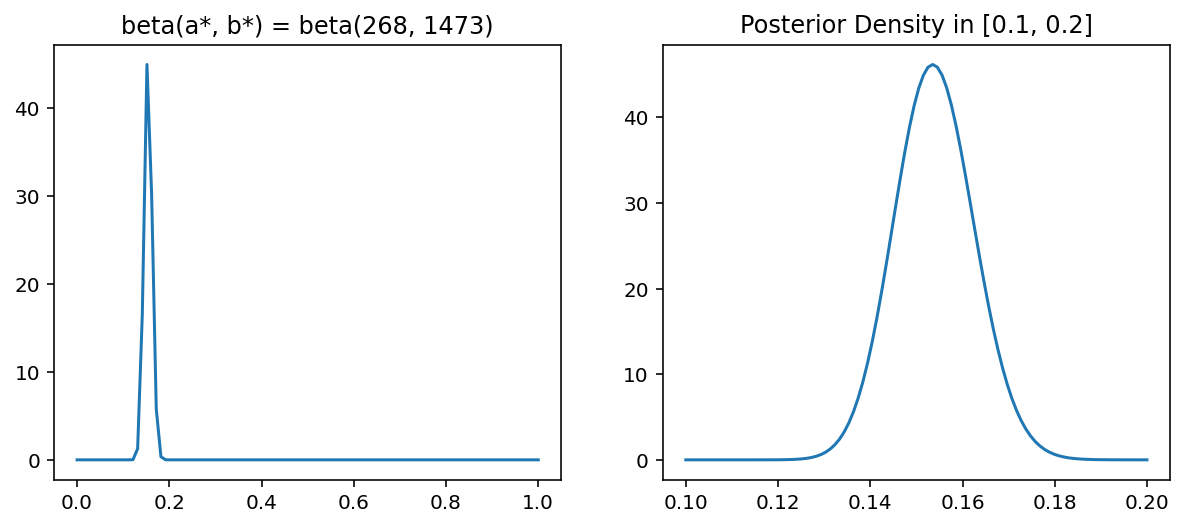

In [22]:
a, b = 1, 1
astar = 1 + sum(y)
bstar = 1 + sum(n) - sum(y)
post = stats.beta(a=astar, b=bstar)

fig, axes = plt.subplots(1,2, figsize=(10,4))
x=np.linspace(0, 1, 100)
pdf = post.pdf(x)
axes[0].plot(x, pdf);
axes[0].set_title(f'beta(a*, b*) = beta({astar}, {bstar})')
lb, ub = .1, .2
x=np.linspace(lb, ub, 100)
pdf = post.pdf(x)
axes[1].plot(x, pdf);
axes[1].set_title(f'Posterior Density in [{lb}, {ub}]');

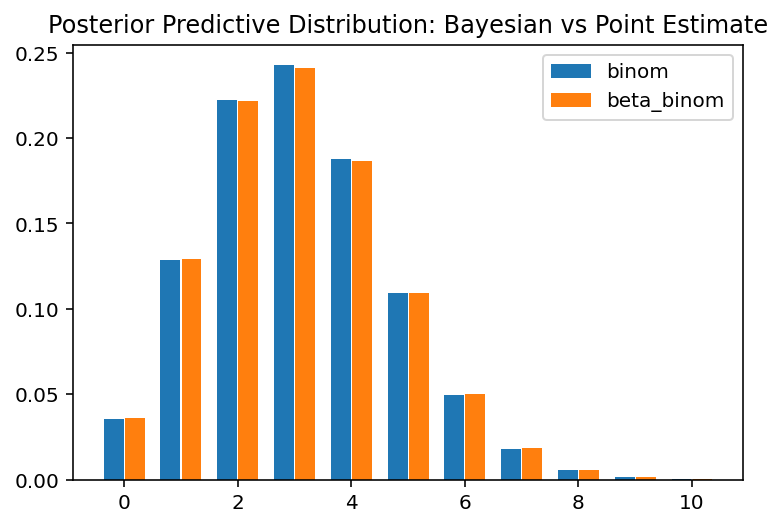

In [51]:
# posterior predictive distribution; nnew = 20
n_new = 20  # if a new study is performed with this number of rats

theta_pmean = astar / (astar + bstar)   # posterior mean
binom = stats.binom(n=n_new, p=theta_pmean)  # binomial from Point Estimate (MAP)
beta_bin = stats.betabinom(n=n_new, a=astar, b=bstar)  # Posterior Averaged

k = np.arange(0, 11); k
binom_pmf = binom.pmf(k)
bb_pmf = beta_bin.pmf(k)
width = .35
plt.bar(k - width/2 - .01, binom_pmf, width=width, label='binom')
plt.bar(k + width/2 + .01, bb_pmf, width=width, label='beta_binom')
plt.legend()
plt.title('Posterior Predictive Distribution: Bayesian vs Point Estimate');

#### 2.5 Posterior Predictive Evaluation of Pooled Model
- Posterior predictive distribution for a new study of size $n$ is beta-binomial (or beta with MAP estimate)
- Compare observed tumor counts in the 71 studies with posterior expected counts for 71 new studies with same sample sizes
- There are more studies with zero or more than 12 tumors than expected by the posterior predictive analysis
- This suggests that different studies may have different tumor probabilities
    - Some very small and some very larger

In [68]:
# Posterior predictive evaluation
# We repeat the study 100 times; that is 100 simulations and make average
def study():
    klist = []
    for ys, ns in zip(y, n):
    #     print(ns)
        # define posterior predictive distribution
        ppd = stats.betabinom(n=ns, a=astar, b=bstar)
        # generate k, the number of tumor cases
        k = ppd.rvs()  # instead, we may generate 100 rvs at once, which should be much faster
        klist.append(k)
    return np.array(klist)
#
n_simul = 100
karray = np.array([ study() for _ in range(n_simul) ] ); karray.shape

(100, 71)

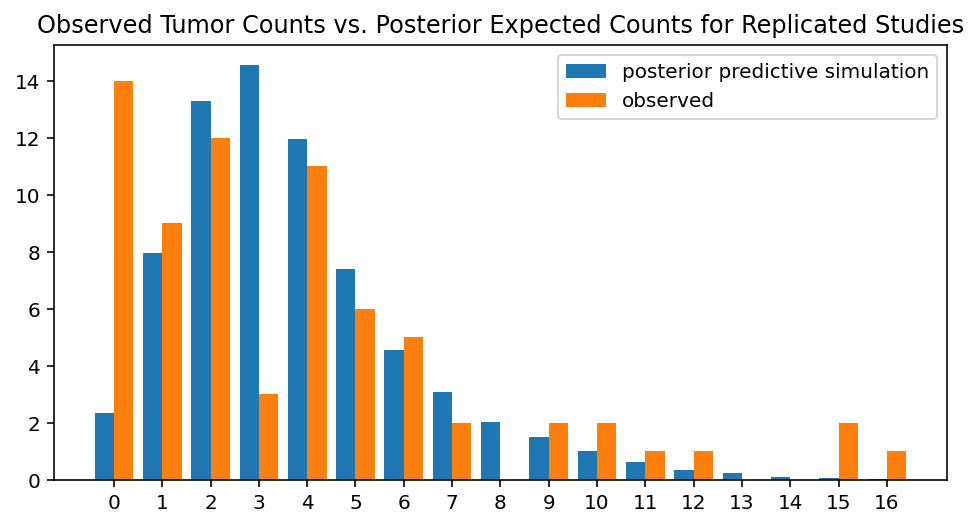

In [83]:
plt.figure(figsize=(8,4))
width = .4  # for bar graph

kcnt, kvals = np.histogram(karray.ravel(), bins=range(18))
kavg = kcnt / 100.
plt.bar(kvals[:-1] - width/2, kavg, width=width, label='posterior predictive simulation')

cnt, kvals = np.histogram(y, bins=range(18))
plt.bar(kvals[:-1] + width/2, cnt, width=width, label='observed')

plt.legend()
plt.title('Observed Tumor Counts vs. Posterior Expected Counts for Replicated Studies')
plt.xticks(range(17));

# References

1. http://www.mas.ncl.ac.uk/~nmf16/teaching/mas3301/ ; Lecture notes, problems, and solutions. Good.
1. http://seor.vse.gmu.edu/~klaskey/SYST664/SYST664.html; PPT notes and course syllabus. Good